<a href="https://colab.research.google.com/github/isa-ulisboa/greends-pml/blob/main/fast_ai_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting survival of Titanic passengers

Works with fastai version 2.7.11

In [1]:
#!pip install -q fastai --upgrade



In [2]:
import fastai
print(fastai.__version__)

2.7.12


In [3]:
from fastai import *
from fastai.tabular.all import *
import pandas as pd

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load data

In [5]:
train_df = pd.read_csv('/content/drive/MyDrive/AAA/Lesson_5/titanic_data/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/AAA/Lesson_5/titanic_data/test.csv')
print(train_df.shape,test_df.shape)
train_df.head()

(891, 12) (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Feature engineering
- Extract *Title* from the name colum. 
- Extract *Deck* from the first character of the cabin number.
- Fill in missing *Age* values with the mean age for passengers with the same title.

In [6]:
for df in [train_df, test_df]:
    df['Title'] = df['Name'].str.split(',').str[1].str.split(' ').str[1]
    df['Deck'] = df['Cabin'].str[0]

# find mean age for each Title across train and test data sets
all_df = pd.concat([train_df, test_df], sort=False)
mean_age_by_title = all_df.groupby('Title').mean()['Age']
# update missing ages
for df in [train_df, test_df]:
    for title, age in mean_age_by_title.iteritems():
        df.loc[df['Age'].isnull() & (df['Title'] == title), 'Age'] = age

<ipython-input-6-dcf17dc8baed>:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_age_by_title = all_df.groupby('Title').mean()['Age']
<ipython-input-6-dcf17dc8baed>:10: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for title, age in mean_age_by_title.iteritems():


In [7]:
test_df.Fare.fillna(0,inplace=True)

In [8]:
train_df.shape

(891, 14)


## Fastai setup

In [9]:
dep_var = 'Survived'
cat_names = ['Pclass', 'Sex', 'Embarked', 'Title', 'Deck']
cont_names = ['Age', 'Fare', 'SibSp', 'Parch']
procs = [FillMissing,Categorify, Normalize] #, 

The last part is the list of pre-processors we apply to our data:

1. `Categorify` is going to take every categorical variable and make a map from integer to unique categories, then replace the values by the corresponding index.
2. `FillMissing` will fill the missing values in the continuous variables by the median of existing values (you can choose a specific value if you prefer)
3. `Normalize` will normalize the continuous variables (subtract the mean and divide by the std)


In [11]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names=cat_names ,
                   cont_names = cont_names,
                   y_names=dep_var,
                   splits=splits,
                   y_block = CategoryBlock) # when y's are 0/1 but we don't want to do regression


In [12]:
dls = to.dataloaders(bs=64) # dataloaders

`Tabularpandas` creates some encoding for the categorical variables. For instance, `Title` is encoded into the following numerical values.

In [100]:
to.train.items['Title']


470    12
203    12
266    12
653     9
170    12
       ..
4      12
668    12
296    12
457    13
890    12
Name: Title, Length: 713, dtype: int8

The next step is to build the learner, which is a multi-layer neural network, and includes layers for **categorical embedding**.

In [21]:
learn = tabular_learner(dls, metrics=accuracy)

`learn.model` does a preview of the model. Note that  `LinBnDrop` is a module grouping three components: `BatchNorm1d`, `Dropout` and Linear layers

In [22]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(4, 3)
    (1): Embedding(3, 3)
    (2): Embedding(4, 3)
    (3): Embedding(18, 8)
    (4): Embedding(9, 5)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=26, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=200, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=2, bias=True)
    )
  )
)

### Let's look at the categorical embedding part of the network:

For fundamentals, see paper "Entity Embeddings of Categorical Variables" https://arxiv.org/abs/1604.06737. The idea is training a neural network for classification. The encoding emerges from the training of the neural network as illustrated by the figure below.

<img src="https://github.com/isa-ulisboa/greends-pml/blob/main/images/NN_categorical_embedding.png?raw=1" width=800>


In [49]:
print(cat_names)
print('number categories for Title:',len(train_df['Title'].unique()),train_df['Title'].unique()) # same as list(train_df['Title'].astype('category').cat.categories.values)
print('number categories for Deck:',len(train_df['Deck'].unique()),train_df['Deck'].unique())
print(learn.model.embeds) # one row per categorial variable Notice that: cat_names = ['Pclass', 'Sex', 'Embarked', 'Title', 'Deck']

['Pclass', 'Sex', 'Embarked', 'Title', 'Deck']
number categories for Title: 17 ['Mr.' 'Mrs.' 'Miss.' 'Master.' 'Don.' 'Rev.' 'Dr.' 'Mme.' 'Ms.' 'Major.'
 'Lady.' 'Sir.' 'Mlle.' 'Col.' 'Capt.' 'the' 'Jonkheer.']
['Capt.', 'Col.', 'Don.', 'Dr.', 'Jonkheer.', 'Lady.', 'Major.', 'Master.', 'Miss.', 'Mlle.', 'Mme.', 'Mr.', 'Mrs.', 'Ms.', 'Rev.', 'Sir.', 'the']
number categories for Deck: 9 [nan 'C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']
ModuleList(
  (0): Embedding(4, 3)
  (1): Embedding(3, 3)
  (2): Embedding(4, 3)
  (3): Embedding(18, 8)
  (4): Embedding(9, 5)
)


One could use  `lr_find` to find a good learning rate: we're just going to use 0.003.

In [50]:
learn.fit_one_cycle(12, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.670385,0.702629,0.415730,00:00
1,0.642875,0.685480,0.455056,00:00
2,0.603299,0.594231,0.691011,00:00
3,0.553552,0.453765,0.792135,00:00
4,0.522766,0.439754,0.769663,00:00
5,0.489114,0.456848,0.786517,00:00
6,0.464600,0.412535,0.803371,00:00
7,0.442358,0.423940,0.825843,00:00
8,0.424968,0.426327,0.820225,00:00
9,0.409392,0.440616,0.814607,00:00


### Replace each categorical value with its embedding vector

The function below returns the embedings for all categorical variables, which are listed under  `cat_names`:

In [101]:
# from https://towardsdatascience.com/entity-embeddings-for-ml-2387eb68e49
def embed_features(learner, xs):
  """
  learner: fastai Learner used to train the neural net
  xs: DataFrame containing input variables. Categorical values are defined by their rank. 
  return:: copy of `xs` with embeddings replacing each categorical variable
  """
  xs = xs.copy()
  for i,col in enumerate(learn.dls.cat_names):
    
    # get matrix containing each row's embedding vector
    emb = learn.model.embeds[i]
    emb_data = emb(tensor(xs[col], dtype=torch.int64))
    emb_names = [f'{col}_{j}' for j in range(emb_data.shape[1])]
    
    # join the embedded category 
    feat_df = pd.DataFrame(data=emb_data, index=xs.index,               
                           columns=emb_names)
    #xs = xs.drop(col, axis=1)
    xs = xs.join(feat_df)
  return xs


For one particular categorical variable (`Title`) let's look at the embeddings. Each value of the categorical variable has the same embedding. In this case, the original set of values of the categorical variable is now represented as vectors of dimension 8.

In [73]:
# show embeddings and raw (original) variables
emb_train_xs = embed_features(learn, to.train.xs)
# names of columns with 'Title'
colsTitle=[x for x in emb_train_xs.columns if 'Title' in x]
# show first columns and only Title columns
emb_train_xs[colsTitle].head(12)

,Title,Title_0,Title_1,Title_2,Title_3,Title_4,Title_5,Title_6,Title_7
470,12,-0.083669,0.067149,-0.071082,0.034945,-0.048484,0.069588,-0.058171,0.010866
203,12,-0.083669,0.067149,-0.071082,0.034945,-0.048484,0.069588,-0.058171,0.010866
266,12,-0.083669,0.067149,-0.071082,0.034945,-0.048484,0.069588,-0.058171,0.010866
653,9,0.040007,-0.058514,0.057415,-0.046886,0.052875,-0.006102,0.013044,-0.035303
170,12,-0.083669,0.067149,-0.071082,0.034945,-0.048484,0.069588,-0.058171,0.010866
234,12,-0.083669,0.067149,-0.071082,0.034945,-0.048484,0.069588,-0.058171,0.010866
486,13,0.096378,-0.072510,0.063045,-0.085908,-0.031697,-0.087547,0.087036,-0.022894
863,9,0.040007,-0.058514,0.057415,-0.046886,0.052875,-0.006102,0.013044,-0.035303
301,12,-0.083669,0.067149,-0.071082,0.034945,-0.048484,0.069588,-0.058171,0.010866
56,9,0.040007,-0.058514,0.057415,-0.046886,0.052875,-0.006102,0.013044,-0.035303


In [102]:
# remove original variable from the set of embedding variables
if 'Title' in colsTitle:
  colsTitle.remove('Title')

## Plot the embeddings for variable `Title`

Fisrt, let's associate to each level of the categorical variable the numeric encoding assign by `tabularpandas`:

In [116]:
title_df=pd.merge(to.train.items.loc[:,'Title'], train_df.loc[:,'Title'], left_index=True,right_index=True) # .loc[:,'Title'] returns a Series, but preserves the index
title_df.columns=['Code','Title']
title_df=title_df.dropna().drop_duplicates() # remove NaN and duplicates
title_df=title_df.sort_values('Code') # sort
print(title_df)

     Code      Title
745     1      Capt.
694     2       Col.
30      3       Don.
632     4        Dr.
822     5  Jonkheer.
556     6      Lady.
449     7     Major.
480     8    Master.
653     9      Miss.
710    10      Mlle.
369    11       Mme.
470    12        Mr.
486    13       Mrs.
443    14        Ms.
886    15       Rev.
599    16       Sir.


Then, we combine the embeddings of the categorical variable `Title` with its original labels, and project the embeddings on the principal components plane to visualize the embeddings in two dimensions.

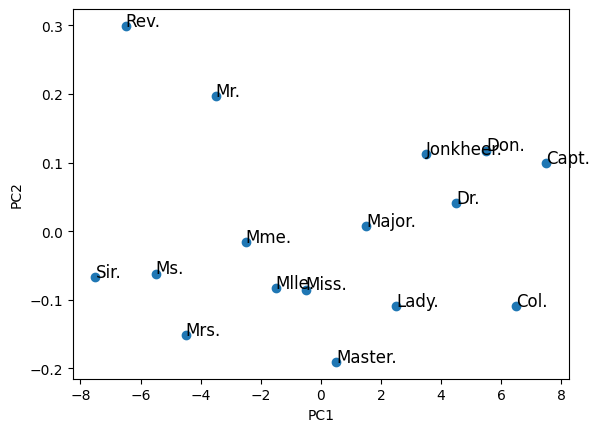

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
import seaborn as sns
titleCols=[x for x in emb_train_xs.columns if 'Title' in x]
X=array(emb_train_xs[titleCols])
y=array(to.train.items['Title'])
# concatenate X and y
Z=np.concatenate((X,np.reshape(y, (X.shape[0], 1))),axis=1)
# remove duplicates
Z=np.unique(Z, axis=0)
# re-create X and y 
X=Z[:, :-1]
y=Z[:,-1]
# perform PCA
pca = PCA(n_components=3)
pca.fit(X)
X_pca = pca.transform(X)
# Plot individual in the PCA principal plane 
first=0 # axis
second=1 # axis
plt.scatter(X_pca[:, first], X_pca[:, second])
for i in range(len(y)):
    plt.text(X_pca[i, first], X_pca[i, second], title_df['Title'].iloc[i], fontsize=12)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


Create a *contigency table* for `Survived` and `Title`: values `Miss`, `Master` and `Mrs` are much more likely to survive than `Mr`. So, the PCA plot seems to separate the encodings of the titles with high survival rates from the titles with low survival rates. 

In [118]:
ct=pd.crosstab(train_df['Survived'], train_df['Title'])
ct

Title,Capt.,Col.,Don.,Dr.,Jonkheer.,Lady.,Major.,Master.,Miss.,Mlle.,Mme.,Mr.,Mrs.,Ms.,Rev.,Sir.,the
Survived,,,,,,,,,,,,,,,,,
0,1,1,1,4,1,0,1,17,55,0,0,436,26,0,6,0,0
1,0,1,0,3,0,1,1,23,127,2,1,81,99,1,0,1,1
